<a href="https://colab.research.google.com/github/ap1809/ChestNet/blob/main/Pneumonia_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import itertools
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [4]:
labels=['NORMAL','PNEUMONIA']
img_size=150

def load_data(data_dir):
    output=[]
    for label in labels:
        path=os.path.join(data_dir,label)
        class_name=labels.index(label)
        for img in os.listdir(path):
            image = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (img_size, img_size))
            output.append([image,class_name])
    return np.array(output,dtype='object')


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train=load_data('/content/drive/My Drive/chest_xray/train')
test=load_data('/content/drive/My Drive/chest_xray/test')
val=load_data('/content/drive/My Drive/chest_xray/val')

<Axes: xlabel='labels', ylabel='count'>

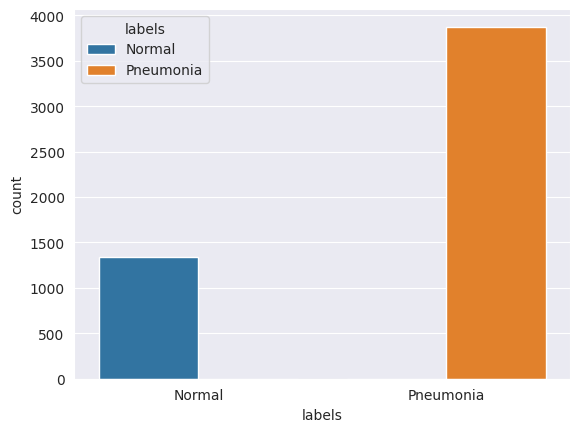

In [7]:
l = []
train_labels=[]
for i in train:
    if i[1] == 0:
        l.append("Normal")
        train_labels.append(i[1])
    else:
        l.append("Pneumonia")
        train_labels.append(i[1])
df = pd.DataFrame({'labels': l})
sns.set_style('darkgrid')
sns.countplot(x='labels',hue='labels', data=df)

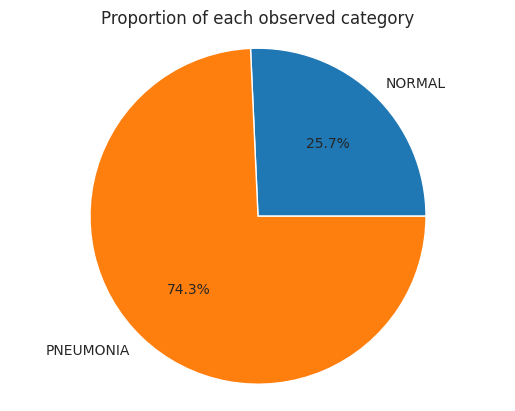

In [8]:
_, train_counts = np.unique(train_labels, return_counts=True)
plt.pie(train_counts,
        labels=labels,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [9]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [10]:
x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [11]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [12]:
train_path='/content/drive/My Drive/chest_xray/train'
test_path='/content/drive/My Drive/chest_xray/test'
val_path='/content/drive/My Drive/chest_xray/val'
os.listdir(train_path+'/PNEUMONIA')[0]

'person543_virus_1073.jpeg'

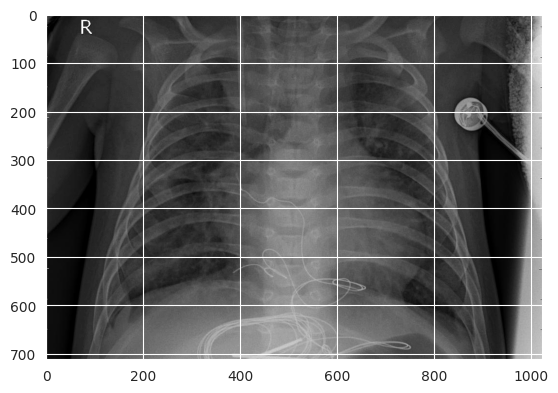

In [13]:
pneu_xray=train_path+'/PNEUMONIA/person1180_virus_2010.jpeg'
plt.imshow(imread(pneu_xray),cmap='gray')

In [14]:
os.listdir(train_path+'/NORMAL')[0]

'IM-0525-0001.jpeg'

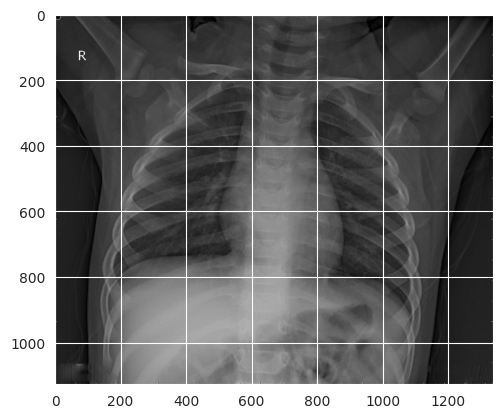

In [15]:
norm_xray=train_path+'/NORMAL/NORMAL2-IM-0771-0001.jpeg'
plt.imshow(imread(norm_xray),cmap='gray')

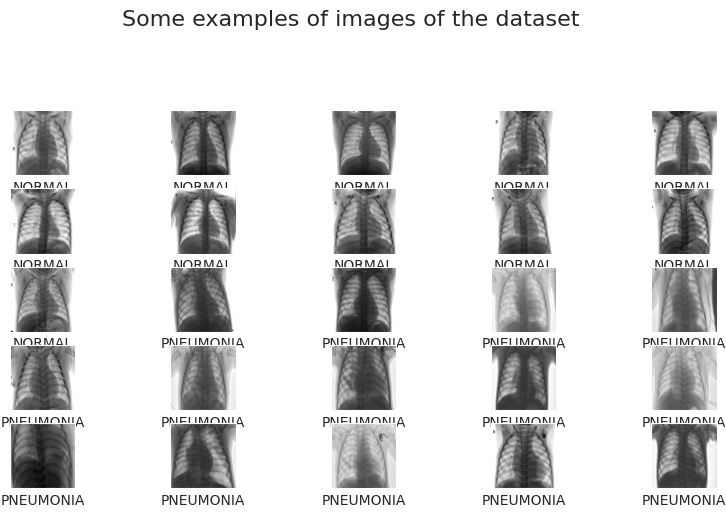

In [16]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Some examples of images of the dataset", fontsize=16)
for i in range(25):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train[1330+i][0], cmap=plt.cm.binary)
    plt.xlabel(labels[train_labels[1330+i]])
plt.show()

In [17]:
img_size=(150,150,1)
image_gen=ImageDataGenerator(rotation_range=20,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            fill_mode='nearest',
                            )

In [18]:
image_gen.fit(x_train)



In [19]:
image_gen.fit(x_test)


In [20]:
image_gen.fit(x_val)


In [64]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = img_size))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_8 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 dropout_6 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 batch_normalization_9 (Batc  (None, 75, 75, 32)      

In [66]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [24]:
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [67]:
results=model.fit(image_gen.flow(x_train,y_train,batch_size=32),epochs=100,
                            validation_data=image_gen.flow(x_val,y_val),
                            callbacks=[learning_rate_reduction])

Epoch 1/100
163/163 [==============================] - 17s 83ms/step - loss: 0.5673 - accuracy: 0.8633 - val_loss: 10.8074 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 12s 76ms/step - loss: 0.2014 - accuracy: 0.9166 - val_loss: 24.5004 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - ETA: 0s - loss: 0.1834 - accuracy: 0.9279
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 12s 76ms/step - loss: 0.1834 - accuracy: 0.9279 - val_loss: 4.3532 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 12s 76ms/step - loss: 0.1500 - accuracy: 0.9440 - val_loss: 4.3894 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/100
163/163 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9463
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [===================

In [68]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 10ms/step - loss: 0.3019 - accuracy: 0.9022
Loss of the model is -  0.3018881380558014
20/20 [==============================] - 0s 11ms/step - loss: 0.3019 - accuracy: 0.9022
Accuracy of the model is -  90.22436141967773 %


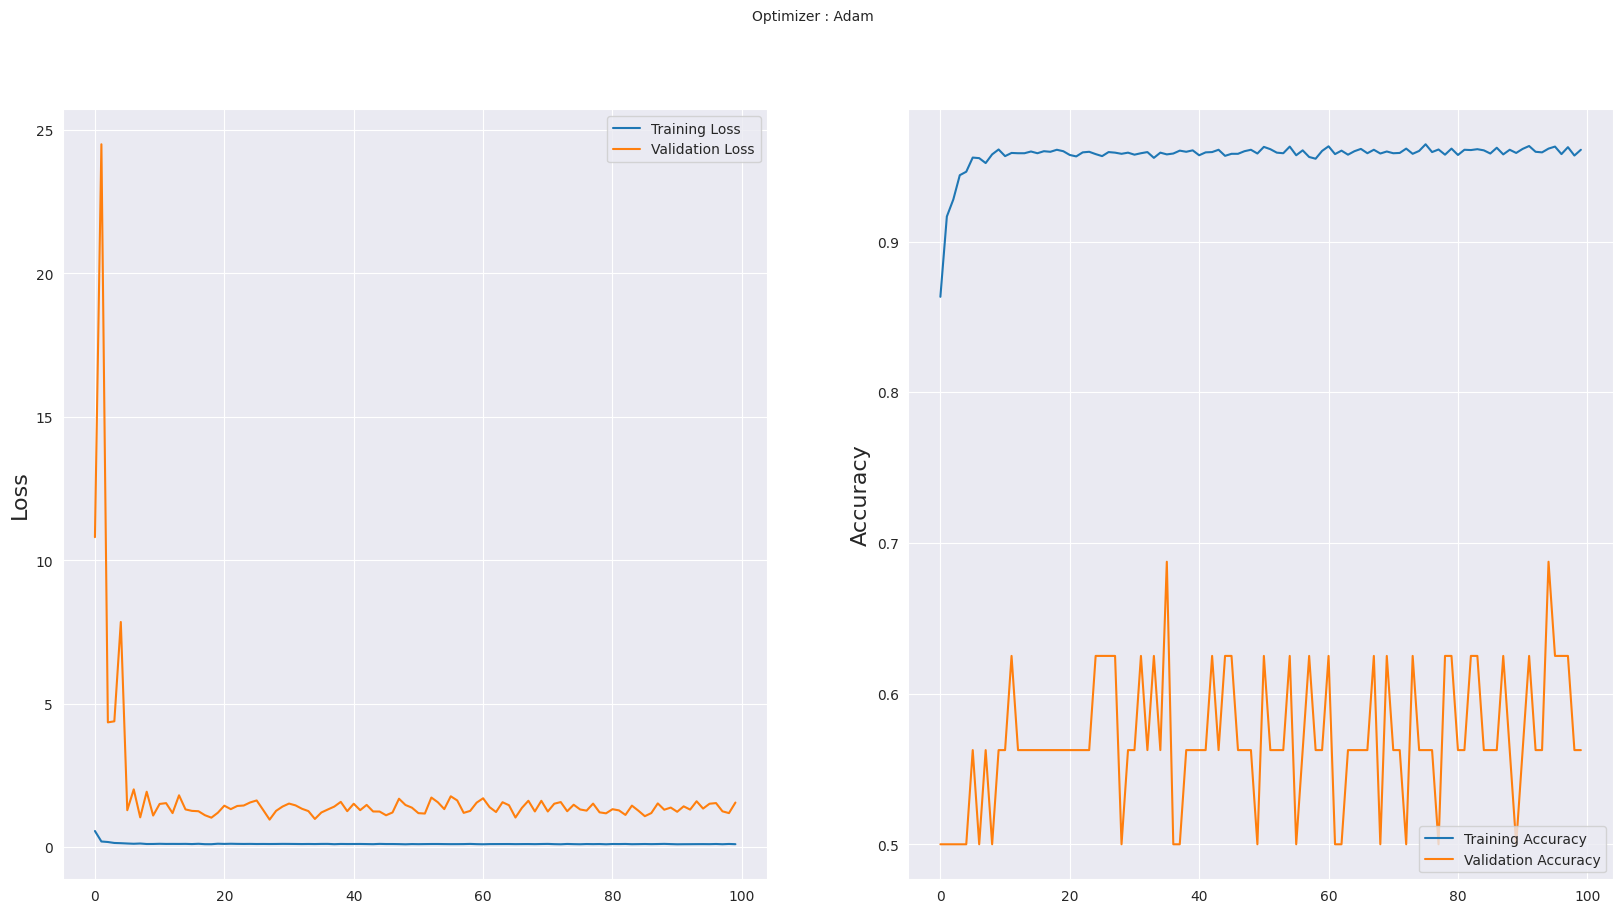

In [69]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(results.history['loss'], label='Training Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(results.history['accuracy'], label='Training Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [70]:
predictions = model.predict(x_test)
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print(classification_report(y_test,y_pred))

20/20 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       234
           1       0.89      0.97      0.93       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



In [71]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8,8))
    plt.grid(None)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

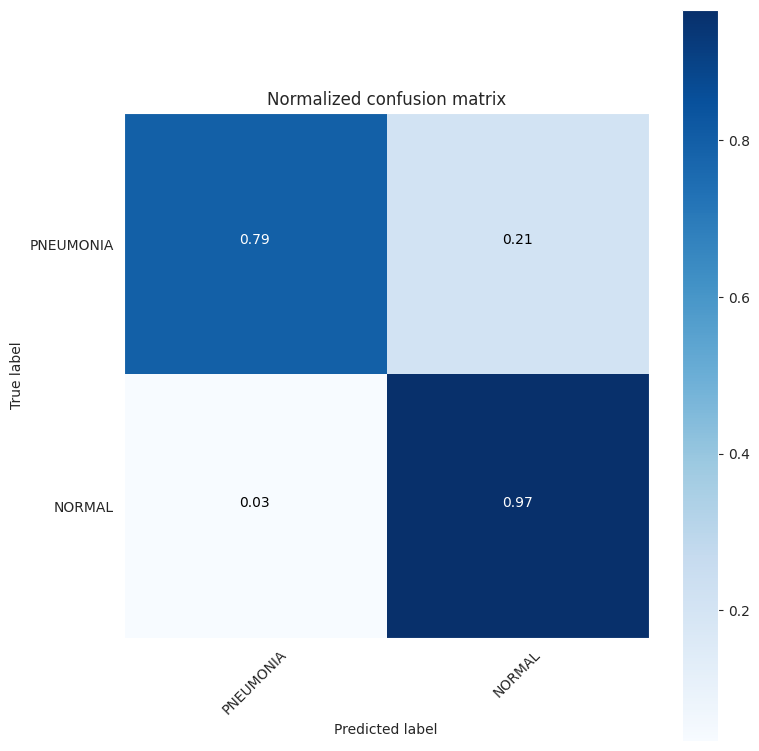

In [73]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["PNEUMONIA", "NORMAL"], title='Normalized confusion matrix')
plt.show()

In [75]:
batch_size = 10  # Specify the desired batch size
random_indices = np.random.choice(len(x_test), size=batch_size, replace=False)  # Randomly select indices
batch_images = x_test[random_indices]  # Get the batch of images
batch_labels = y_test[random_indices]
batch_predictions = model.predict(batch_images)

batch_predictions=batch_predictions>0.5

1/1 [==============================] - 0s 75ms/step


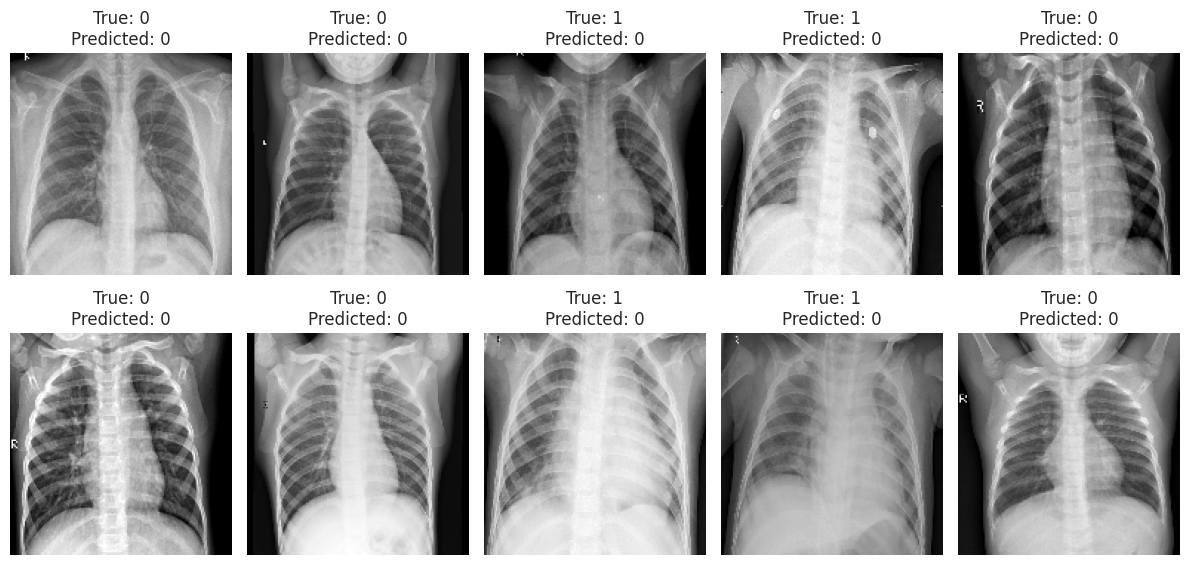

In [76]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=batch_size // 2, figsize=(12, 6))

# Iterate over the images and their corresponding labels and predictions
for i, (image, label, prediction) in enumerate(zip(batch_images, batch_labels, batch_predictions)):
    # Set the current axis
    ax = axes[i // (batch_size // 2), i % (batch_size // 2)]
    ax.imshow(image,cmap='gray')
    ax.axis('off')
    ax.set_title(f"True: {label}\nPredicted: {np.argmax(prediction)}")

plt.tight_layout()

plt.show()


In [81]:
model.save("my_model.h5", include_optimizer=True)

In [83]:
from google.colab import files

files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>